## Crime Report - NSW Summary

### Crime Trend

The overall crime trend for NSW is downward, decreasing 7% from 2013 to 2018 in
raw crime figures and a decrease of 14% from 2013 to 2018 per capita. 

year
2018    445447
Name: total, dtype: int64

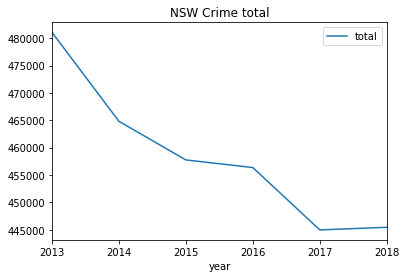

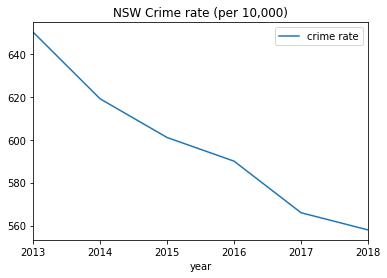

In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import r2_score, mean_squared_error as MSE


crimeTS = pd.read_csv("data/crimeTS.gzip", compression="gzip")
crimeDS = pd.read_csv("data/crimeDS.gzip", compression="gzip")
lga_trend = crimeTS[['LGA', 'total', 'population', 'year']].groupby(['year', 'LGA', 'population']).sum().reset_index()
trend = lga_trend.groupby('year').sum()
trend['crime rate'] = trend.total.div(trend.population).mul(1e4).round()
trend.plot(y='total', title="NSW Crime total")
trend.plot(y='crime rate', title="NSW Crime rate (per 10,000)")
#crimeDS[crimeDS.LGA == 'Sydney'].groupby('year').sum().Total
crimeTS[(crimeTS.year == 2018)].groupby('year').sum().total

In [23]:
33871/445447

0.07603822676996365

### Crime Distribution for 2018

To analyse the crime rates of NSW regions, we focus on those with populations greater
than 20,000 as a handful of crimes in small areas skew results.  

The median crime rate in 2018 was 527 per 10,000 with a standard deviation of 248 per 10,000. 

Sydney is the biggest outlier at 1410 crimes per 10,000 in 2018, followed by Dubbo Regional. 

     year                LGA  population  total  crime rate
745  2018             Sydney      240229  33871      1410.0
676  2018     Dubbo Regional       53240   7048      1324.0
699  2018            Kempsey       29665   3301      1113.0
754  2018        Wagga Wagga       64820   6149       949.0
641  2018  Armidale Regional       30707   2833       923.0


count      69.000000
mean      568.956522
std       248.070995
min       177.000000
25%       393.000000
50%       527.000000
75%       698.000000
max      1410.000000
Name: crime rate, dtype: float64

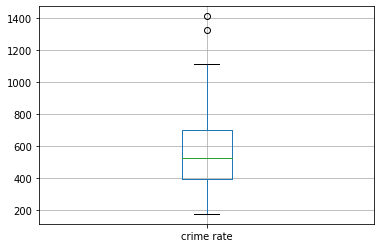

In [9]:
lga_trend['crime rate'] = lga_trend.total.div(lga_trend.population).mul(1e4).round()
lga_year = lga_trend[(lga_trend.year == 2018) & (lga_trend.population > 20000)]
lga_year.boxplot('crime rate')
print(lga_year.sort_values('crime rate', ascending=False).head())
lga_year['crime rate'].describe()

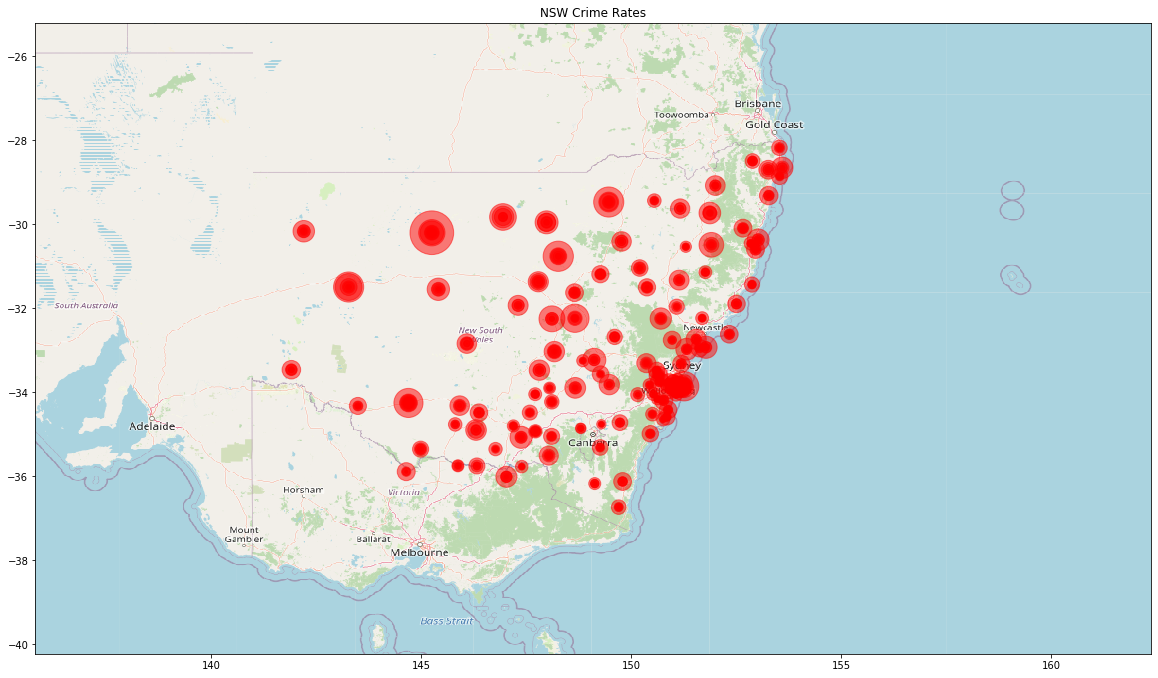

In [12]:
BBox = (135.813, 162.378, -40.229, -25.205)
nsw_map = plt.imread('nsw.png')
fig, ax = plt.subplots(figsize = (20,20))
ax.scatter(crimeDS.long, crimeDS.lat, zorder=1, alpha= 0.5, c='red', s=crimeDS.offence_rate)
ax.set_title('NSW Crime Rates')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(nsw_map, zorder=0, extent = BBox, aspect= 'equal')

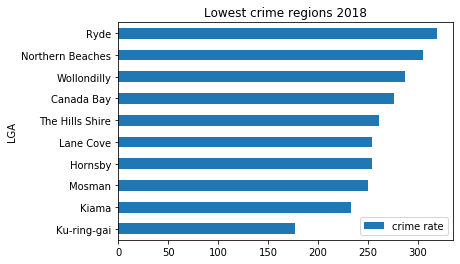

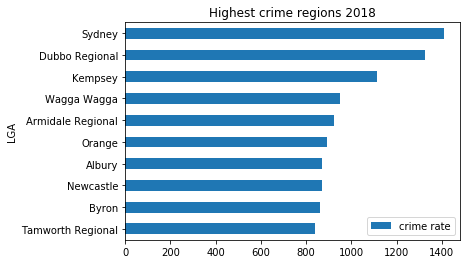

In [197]:
lga_year = lga_year.sort_values(['crime rate'])
lowest = lga_year[:10]
highest = lga_year[-10:]
lowest.plot.barh(x='LGA', y='crime rate', title="Lowest crime regions 2018")
highest.plot.barh(x='LGA', y='crime rate', title="Highest crime regions 2018")

### Trends of Largest Regions

Most of the largest regions had a steady crime rate since 2013 with a slight decrease but it can be seen that
the Sydney LGA had the sharpest decrease which would account for most of the state decrese in crime. 

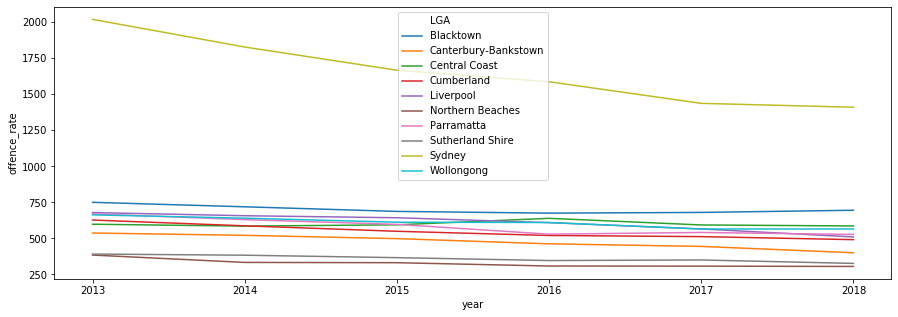

In [198]:
top_cities = crimeTS.loc[crimeTS.year == 2018, [ 'LGA', 'population']].groupby([ 'LGA', 'population']).sum().sort_values('population', ascending=False)[:10].reset_index()
cities = crimeTS.loc[crimeTS.LGA.isin(top_cities.LGA), [ 'LGA', 'population', 'year', 'total']].groupby([ 'LGA', 'population', 'year']).sum().reset_index()
cities['offence_rate'] = cities.total.div(cities.population).mul(1e4).round()
plt.figure(figsize=(15,5))
sns.lineplot(x="year", y="offence_rate", hue="LGA", data=cities)

### Trends by Region

A simple linear regression is performed on each LGA to determine the rate of increase or decrease in crime rates.

,LGA,gradient,mse,r2
121,Sydney,-122.911701,1810.699768,0.960529
93,Gunnedah,-86.177726,7306.056344,0.747780
49,Burwood,-54.007006,351.236704,0.960350
104,Byron,-46.850911,2065.202730,0.756097
90,Griffith,-42.466210,1833.275366,0.741542


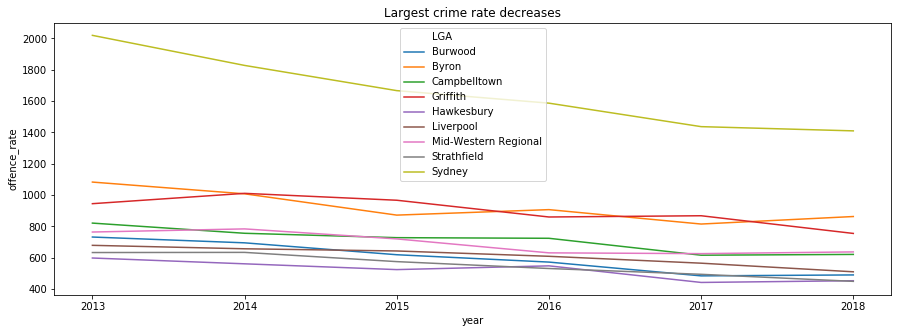

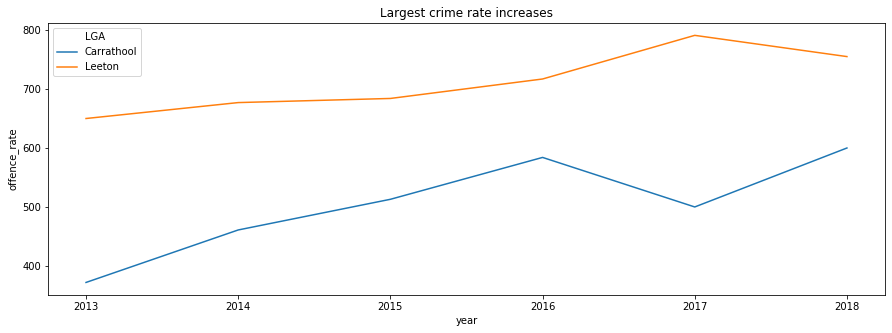

In [199]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline

reg = linear_model.LinearRegression()

lgas = lga_trend.LGA.unique()

df = pd.DataFrame(columns= ['LGA', 'gradient', 'mse', 'r2'])
for lga in lgas: 
    ds = lga_trend[lga_trend.LGA == lga]
    lm = linear_model.LinearRegression()
    y = ds.total.div(ds.population).mul(1e4)
    X = ds[['year']]
    lm.fit(X,y)
    predicted = lm.predict(X)
    mse = MSE(y, predicted)
    r2 = r2_score(y, predicted)
    df = df.append({ 'LGA': lga, 'gradient': lm.coef_[0], 'mse': mse, 'r2': r2 }, ignore_index=True)
    
df = df[df.r2 > 0.7].sort_values('gradient')
decliners = df.LGA[:10]
gainers = df[df.gradient > 0].LGA

#biggest decliners
declines = crimeTS.loc[crimeTS.LGA.isin(decliners) & (crimeTS.population > 20000), [ 'LGA', 'population', 'year', 'total']].groupby([ 'LGA', 'population', 'year']).sum().reset_index()
declines['offence_rate'] = declines.total.div(declines.population).mul(1e4).round()
plt.figure(figsize=(15,5))
sns.lineplot(x="year", y="offence_rate", hue="LGA", data=declines).set_title("Largest crime rate decreases")

#biggest gainers
cities = crimeTS.loc[(crimeTS.LGA.isin(gainers)), [ 'LGA', 'population', 'year', 'total']].groupby([ 'LGA', 'population', 'year']).sum().reset_index()
cities['offence_rate'] = cities.total.div(cities.population).mul(1e4).round()
plt.figure(figsize=(15,5))
sns.lineplot(x="year", y="offence_rate", hue="LGA", data=cities).set_title("Largest crime rate increases")

df.head()

As expected, Sydney had the largest crime decrease from 2013 to 2018, followed by Burwood, Byron and Griffith for populations greater than 20,000. The only increases occurred in Carrathool and Leeton which are both in NSW's south-west Riverina region. 

### In Summary 

Overall crime trends have fallen from 2013 to 2018, with Sydney accounting for most of the declining trend.